In [2]:
# import
from shapely.ops import cascaded_union  # , unary_union
import matplotlib.pyplot as plt
import tempfile
import urllib
import base64
import h3
from shapely.geometry import mapping
from geopandas import GeoDataFrame
import xarray as xr
import geopandas
import rtree
import shapely
import pandas as pd
import warnings
import json
warnings.filterwarnings('ignore')

# import matplotlib
%matplotlib inline


In [11]:
from shapely.ops import cascaded_union  # , unary_union

gdf = geopandas.read_file('北京市.json')

temp1 = gdf.to_dict()
temp2 = json.dumps(temp1['geometry'][0].__geo_interface__)
temp = json.loads(temp2)

APERTURE_SIZE = 8
# Unify the CT boundries
# union_poly = cascaded_union(gdf.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list = []
# for n, g in enumerate(union_poly):
#     print(n, '\r')
# temp = mapping(gdf.geometry)
temp['coordinates'] = [[[j[1], j[0]] for j in i]
                       for i in temp['coordinates']]
# hex_list.extend(h3.polyfill(temp, APERTURE_SIZE))

hexes = h3.polyfill(temp, APERTURE_SIZE)
compact_hexes = h3.compact(hexes)
hex_list.extend(compact_hexes)

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list, columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex
dfh['lat'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng'] = dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
# dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng, x.lat), 1)
# dfh.crs = {"init": "epsg:4326"}

# # plot hex latlng
# dfh.plot(x='lng', y='lat', style='.', figsize=(7, 7))
# plt.title('hex-grid: nyc')
# dfh = GeoDataFrame(dfh)
# # Intersect Hex Point with CT Polygon
# df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
# df_ct.sample(3)


Sanity Check
number of hexes: 1829
number of duplicates: 0


In [12]:
hexagons = compact_hexes
geojson_out = {
    "type": "FeatureCollection",
    "features": []
}

for i in hexagons:
    geojson_out["features"].append({
        "type": "Feature",
        "properties": {
            "identifier": i
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                h3.h3_to_geo_boundary(i, geo_json=True)
            ]
        }
    })

with open("output.geojson", "w") as outfile:
    json.dump(geojson_out, outfile)


In [13]:
print(len(hexes))
print(len(compact_hexes))


31055
1829


(115.31418343161197, 117.62140384041369, 39.35560399538481, 41.14528623707017)

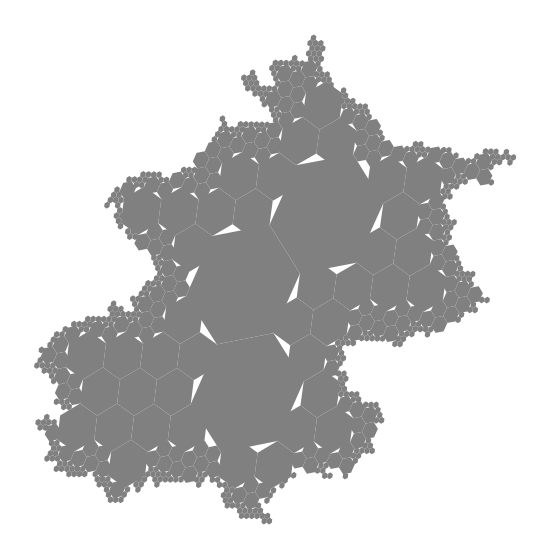

In [4]:
# ax = gdf.plot(figsize=(7, 7), color='red')
tempRes = geopandas.read_file('output.geojson')
ax = tempRes.plot( color = 'grey', figsize = (7, 7))
ax.axis('off')